In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, accuracy_score, roc_curve, auc
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

In [105]:
# Set up testing dataframes

"""                                    Data Dictionary
Variable	    Definition	                                        Key
Survived	    Survival	                                        0 = No, 1 = Yes
Pclass	        Ticket class	                                    1 = 1st, 2 = 2nd, 3 = 3rd
Name            Passenger Name
Sex	            Sex
Age	            Age in years	
SibSp	        # of siblings / spouses aboard the Titanic	
Parch	        # of parents / children aboard the Titanic	
Ticket	        Ticket number	
Fare	        Passenger fare	
Cabin	        Cabin number	
Embarked	    Port of Embarkation                                 C = Cherbourg, Q = Queenstown, S = Southampton
"""

train_set = pd.read_csv('train.csv')
train, test = train_test_split(train_set, random_state=42, test_size=0.25)

In [106]:
# Will deal with 'Ticket' and 'Cabin' columns later, because these columns will need to be classified. Possibly 'Name' as well
cat = ['Sex', 'Embarked']
num = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Test vars in logistic regression model
y = train['Survived']
X = train[cat + num]
X = X.fillna({
    'Pclass': X['Pclass'].mean(),
    'Age': X['Age'].mean(),
    'SibSp': X['SibSp'].mean(),
    'Parch': X['Parch'].mean(),
    'Fare': X['Fare'].mean()
})

In [107]:
cat_trans = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
num_trans = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_trans, num),
        ('cat', cat_trans, cat)
    ]
)

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])


model = model.fit(X[cat+num], y)

In [108]:
X_test = test[cat+num]
X_test = X_test.fillna({
    'Pclass': 0,
    'Age': 0,
    'SibSp': 0,
    'Parch': 0,
    'Fare': 0
})
y_test = test['Survived']

acc1 = accuracy_score(y_test, model.predict(X_test))
cv1 = cross_val_score(model, X, y, cv=5)

print(acc1, '\n', cv1, sep='')


0.8026905829596412
[0.79850746 0.84328358 0.79104478 0.7443609  0.80451128]


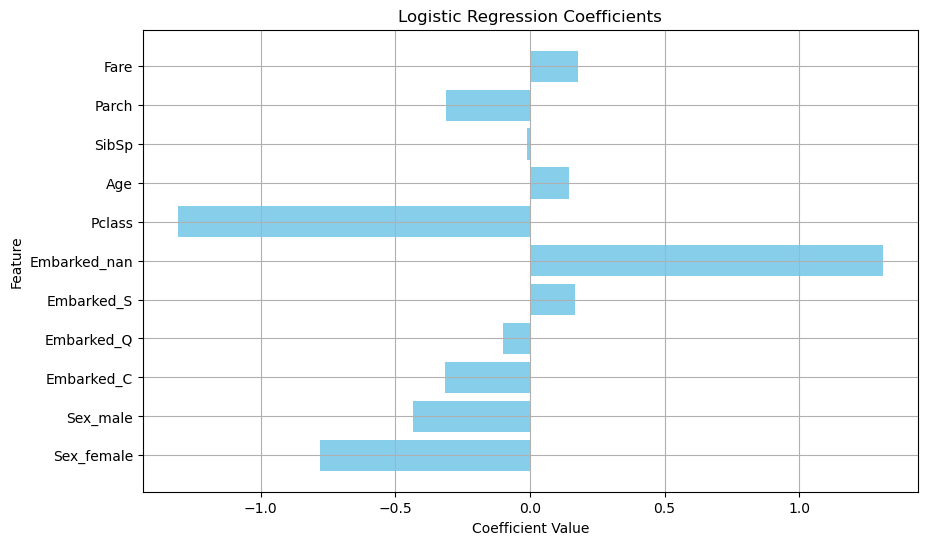

In [111]:
logistic_model = model.named_steps['classifier']
categorical_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat)
numerical_feature_names = num
feature_names = list(categorical_feature_names) + numerical_feature_names
coefficients = logistic_model.coef_.flatten()

plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.grid(True)
plt.show()

In [ ]:
test_set = pd.read_csv('test.csv')